In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.combine import SMOTEENN
from boruta import BorutaPy
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasSGDOptimizer
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
import os

In [17]:

os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Load data
data_path = 'C:/Users/danie/OneDrive/Documentos/1 UNIANDES/10 semestre/Tesis/differential-privacy-banking-sector/data/processed/bank-processed.csv'
data = pd.read_csv(data_path, sep=',')
print(data.shape)

# Separate features and target
X = data.drop(columns=['y'])
y = data['y']

# Define numeric columns
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Scale numeric columns
scale = MinMaxScaler()
X[numeric_cols] = scale.fit_transform(X[numeric_cols])

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


(45211, 33)


In [18]:

# Apply SMOTEENN for class balancing
smoteenn = SMOTEENN(random_state=42)
X_resample, y_resample = smoteenn.fit_resample(X_train, y_train)
X_resample = pd.DataFrame(X_resample, columns=X.columns)
y_resample = pd.Series(y_resample)


In [19]:
# Feature selection with BorutaPy
rf = xgb.XGBClassifier(eval_metric='logloss')
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
feat_selector.fit(X_resample.values, y_resample.values.ravel())
X_filtered = X.columns[feat_selector.support_].tolist()
print(f"Selected features: {len(X_filtered)}")


c:\Users\danie\OneDrive\Documentos\1 UNIANDES\10 semestre\Tesis\differential-privacy-banking-sector\cdp\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Selected features: 26


In [20]:
# Filter data with selected features
X_train_filtered = X_resample[X_filtered].values
X_test_filtered = X_test[X_filtered].values
y_train_filtered = y_resample.values
y_test_filtered = y_test.values


In [ ]:

# Neural network parameters
input_size = len(X_filtered)
hidden_units = 64
hidden_layers = 2
dropout_rate = 0.2
learning_rate = 0.001 # previously 0.0001
epochs = 50
n_iterations = 3
# num_microbatches = batch_size
l2_norm_clip = 1.0

# Define parameter values to test
batch_size_values = [16, 32, 64, 128]
sample_size_ratio_values = [1, 0.5, 0.1, 0.05]
noise_multiplier_values = [1.1, 1.5, 2.0, 2.5]

# Fixed default values
default_noise_multiplier = 1.1
default_batch_size = 16


In [ ]:
# Function to compute privacy budget
def compute_privacy_budget(n, batch_size, noise_multiplier, epochs, delta=1e-5):
    try:
        eps = compute_dp_sgd_privacy.compute_dp_sgd_privacy(
            n=n, batch_size=batch_size, noise_multiplier=noise_multiplier,
            epochs=epochs, delta=delta
        )[0]
        return eps
    except Exception as e:
        print(f"Error computing privacy budget: {e}")
        return float('inf')

# Define neural network model
def create_model(input_size, hidden_units, hidden_layers, dropout_rate, num_microbatches, use_dp=False,
                 l2_norm_clip=l2_norm_clip, noise_multiplier=1.1):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_shape=(input_size,)))
    for _ in range(hidden_layers - 1):
        model.add(Dense(hidden_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    if use_dp:
        optimizer = DPKerasSGDOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=num_microbatches,
            learning_rate=learning_rate
        )
    else:
        optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to train model
def train_model(X_train, y_train, X_test, y_test, batch_size, epochs, use_dp=False,
                l2_norm_clip=l2_norm_clip, noise_multiplier=1.1):
    model = create_model(input_size, hidden_units, hidden_layers, dropout_rate, use_dp=use_dp, 
                         num_microbatches=batch_size, l2_norm_clip=l2_norm_clip, noise_multiplier=noise_multiplier)
    
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, y_test)
    )
    
    y_pred_prob_test = model.predict(X_test, batch_size=batch_size).flatten()
    y_pred_test = (y_pred_prob_test > 0.5).astype(int)
    
    return y_pred_prob_test, y_pred_test

# Function to evaluate model
def evaluate_model(y_true, y_pred, y_pred_prob):
    conf_matrix = confusion_matrix(y_true, y_pred)
    actual_negatives, actual_positives = conf_matrix[0].sum(), conf_matrix[1].sum()
    false_positive_rate = conf_matrix[0][1] / actual_negatives if actual_negatives > 0 else 0
    false_negative_rate = conf_matrix[1][0] / actual_positives if actual_positives > 0 else 0
    return {
        'ROC AUC': roc_auc_score(y_true, y_pred_prob),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'Type I Error': false_positive_rate,
        'Type II Error': false_negative_rate
    }

# Function to run multiple iterations
def run_iterations(X_train, y_train, X_test, y_test, batch_size, epochs, use_dp, n_iterations, 
                   l2_norm_clip, noise_multiplier):
    results = []
    for _ in range(n_iterations):
        y_pred_prob_test, y_pred_test = train_model(
            X_train, y_train, X_test, y_test, batch_size, epochs, use_dp=use_dp,
            l2_norm_clip=l2_norm_clip, noise_multiplier=noise_multiplier
        )
        result = evaluate_model(y_test, y_pred_test, y_pred_prob_test)
        results.append(result)
    return pd.DataFrame(results)

# Function to compute statistics
def compute_statistics(df):
    stats = {
        'mean': df.mean(),
        'min': df.min(),
        'max': df.max()
    }
    return stats

# Function to subsample training data
def subsample_data(X, y, sample_size_ratio, random_state=42):
    if sample_size_ratio >= 1.0:
        return X, y
    n_samples = int(len(X) * sample_size_ratio)
    idx = np.random.choice(len(X), n_samples, replace=False)
    return X[idx], y[idx]

In [23]:
# Train model without DP
print("Training model without DP...")
results_no_dp = run_iterations(
    X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered,
    batch_size=default_batch_size, epochs=epochs, use_dp=False, n_iterations=n_iterations,
    l2_norm_clip=None, noise_multiplier=None
)
results_no_dp_stats = compute_statistics(results_no_dp)


Training model without DP...
Epoch 1/50
3344/3344 [==============================] - 3s 836us/step - loss: 0.3240 - accuracy: 0.8624 - val_loss: 0.4212 - val_accuracy: 0.8359
Epoch 2/50
3344/3344 [==============================] - 2s 703us/step - loss: 0.2438 - accuracy: 0.9059 - val_loss: 0.4857 - val_accuracy: 0.8095
Epoch 3/50
3344/3344 [==============================] - 2s 694us/step - loss: 0.2269 - accuracy: 0.9109 - val_loss: 0.4242 - val_accuracy: 0.8403
Epoch 4/50
3344/3344 [==============================] - 2s 686us/step - loss: 0.2159 - accuracy: 0.9158 - val_loss: 0.4312 - val_accuracy: 0.8348
Epoch 5/50
3344/3344 [==============================] - 2s 698us/step - loss: 0.2081 - accuracy: 0.9188 - val_loss: 0.5144 - val_accuracy: 0.7848
Epoch 6/50
3344/3344 [==============================] - 2s 675us/step - loss: 0.2010 - accuracy: 0.9227 - val_loss: 0.4209 - val_accuracy: 0.8376
Epoch 7/50
3344/3344 [==============================] - 2s 689us/step - loss: 0.1972 - accuracy

In [24]:
# Run experiments varying parameters
delta = 1e-5

# 1. Vary batch_size
results_batch_size = {}
eps_batch_size = {}
for bs in batch_size_values:
    print(f"\nTraining model with batch_size={bs}...")
    n = len(X_train_filtered)
    eps = compute_privacy_budget(n, bs, default_noise_multiplier, epochs, delta)
    results = run_iterations(
        X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered,
        batch_size=bs, epochs=epochs, use_dp=True, n_iterations=n_iterations,
        l2_norm_clip=l2_norm_clip, noise_multiplier=default_noise_multiplier
    )
    results_batch_size[bs] = compute_statistics(results)
    eps_batch_size[bs] = eps



Training model with batch_size=16...
DP-SGD with sampling rate = 0.0299% and noise_multiplier = 1.1 iterated over 167200 steps satisfies differential privacy with eps = 0.849 and delta = 1e-05.
The optimal RDP order is 19.0.
Epoch 1/50
3344/3344 [==============================] - 2s 526us/step - loss: 0.6616 - accuracy: 0.6027 - val_loss: 0.6549 - val_accuracy: 0.6156
Epoch 2/50
3344/3344 [==============================] - 2s 504us/step - loss: 0.6122 - accuracy: 0.6751 - val_loss: 0.6169 - val_accuracy: 0.6626
Epoch 3/50
3344/3344 [==============================] - 2s 536us/step - loss: 0.5801 - accuracy: 0.7045 - val_loss: 0.6103 - val_accuracy: 0.6520
Epoch 4/50
3344/3344 [==============================] - 2s 516us/step - loss: 0.5583 - accuracy: 0.7223 - val_loss: 0.5782 - val_accuracy: 0.6705
Epoch 5/50
3344/3344 [==============================] - 2s 506us/step - loss: 0.5415 - accuracy: 0.7308 - val_loss: 0.6077 - val_accuracy: 0.6468
Epoch 6/50
3344/3344 [======================

In [25]:
# 2. Vary sample_size_ratio
results_sample_size = {}
eps_sample_size = {}
for ssr in sample_size_ratio_values:
    print(f"\nTraining model with sample_size_ratio={ssr}...")
    X_sub, y_sub = subsample_data(X_train_filtered, y_train_filtered, ssr)
    n = len(X_sub)
    eps = compute_privacy_budget(n, default_batch_size, default_noise_multiplier, epochs, delta)
    results = run_iterations(
        X_sub, y_sub, X_test_filtered, y_test_filtered,
        batch_size=default_batch_size, epochs=epochs, use_dp=True, n_iterations=n_iterations,
        l2_norm_clip=l2_norm_clip,
        noise_multiplier=default_noise_multiplier
    )
    results_sample_size[ssr] = compute_statistics(results)
    eps_sample_size[ssr] = eps
    


Training model with sample_size_ratio=1...
DP-SGD with sampling rate = 0.0299% and noise_multiplier = 1.1 iterated over 167200 steps satisfies differential privacy with eps = 0.849 and delta = 1e-05.
The optimal RDP order is 19.0.
Epoch 1/50
3344/3344 [==============================] - 2s 578us/step - loss: 0.6795 - accuracy: 0.5789 - val_loss: 0.6872 - val_accuracy: 0.5589
Epoch 2/50
3344/3344 [==============================] - 2s 477us/step - loss: 0.6199 - accuracy: 0.6816 - val_loss: 0.6196 - val_accuracy: 0.6579
Epoch 3/50
3344/3344 [==============================] - 1s 438us/step - loss: 0.5774 - accuracy: 0.7127 - val_loss: 0.5724 - val_accuracy: 0.6889
Epoch 4/50
3344/3344 [==============================] - 1s 435us/step - loss: 0.5475 - accuracy: 0.7281 - val_loss: 0.6247 - val_accuracy: 0.6404
Epoch 5/50
3344/3344 [==============================] - 1s 433us/step - loss: 0.5276 - accuracy: 0.7383 - val_loss: 0.5713 - val_accuracy: 0.6822
Epoch 6/50
3344/3344 [================

In [26]:
# 3. Vary noise_multiplier
results_noise_multiplier = {}
eps_noise_multiplier = {}
for noise in noise_multiplier_values:
    print(f"\nTraining model with noise_multiplier={noise}...")
    n = len(X_train_filtered)
    eps = compute_privacy_budget(n, default_batch_size, noise, epochs, delta)
    results = run_iterations(
        X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered,
        batch_size=default_batch_size, epochs=epochs, use_dp=True, n_iterations=n_iterations,
        l2_norm_clip=l2_norm_clip, noise_multiplier=noise
    )
    results_noise_multiplier[noise] = compute_statistics(results)
    eps_noise_multiplier[noise] = eps


Training model with noise_multiplier=1.1...
DP-SGD with sampling rate = 0.0299% and noise_multiplier = 1.1 iterated over 167200 steps satisfies differential privacy with eps = 0.849 and delta = 1e-05.
The optimal RDP order is 19.0.
Epoch 1/50
3344/3344 [==============================] - 2s 528us/step - loss: 0.6577 - accuracy: 0.6059 - val_loss: 0.6420 - val_accuracy: 0.6337
Epoch 2/50
3344/3344 [==============================] - 2s 511us/step - loss: 0.5997 - accuracy: 0.6869 - val_loss: 0.5902 - val_accuracy: 0.6676
Epoch 3/50
3344/3344 [==============================] - 2s 538us/step - loss: 0.5651 - accuracy: 0.7163 - val_loss: 0.6184 - val_accuracy: 0.6266
Epoch 4/50
3344/3344 [==============================] - 2s 512us/step - loss: 0.5436 - accuracy: 0.7294 - val_loss: 0.6041 - val_accuracy: 0.6365
Epoch 5/50
3344/3344 [==============================] - 2s 502us/step - loss: 0.5289 - accuracy: 0.7369 - val_loss: 0.6066 - val_accuracy: 0.6399
Epoch 6/50
3344/3344 [===============

In [27]:
# Save results to CSV
results_stats = {
    'batch_size': results_batch_size,
    'sample_size_ratio': results_sample_size,
    'noise_multiplier': results_noise_multiplier
}
data = {}

# Add results for non-DP model
data['No DP (mean)'] = results_no_dp_stats['mean']
data['No DP (min)'] = results_no_dp_stats['min']
data['No DP (max)'] = results_no_dp_stats['max']

# Add results for DP models
for param, stats_dict in results_stats.items():
    for value, stats in stats_dict.items():
        # Get the corresponding epsilon value based on the parameter
        if param == 'batch_size':
            eps = eps_batch_size.get(value, float('inf'))
        elif param == 'sample_size_ratio':
            eps = eps_sample_size.get(value, float('inf'))
        else:  # noise_multiplier
            eps = eps_noise_multiplier.get(value, float('inf'))
        
        # Format the model name with epsilon (if finite)
        model = f'{param}={value} (ε={eps:.2f})' if eps != float('inf') else f'{param}={value}'
        data[f'{model} (mean)'] = stats['mean']
        data[f'{model} (min)'] = stats['min']
        data[f'{model} (max)'] = stats['max']

# Create DataFrame and save to CSV
results_df = pd.DataFrame(data).round(4)
results_df.to_csv('results/CDP_parameter_results.csv')
print("\nResults saved to 'results/CDP_parameter_results.csv'")
print("\nResults (Averages):\n", results_df[[col for col in results_df.columns if 'mean' in col]])


Results saved to 'results/CDP_parameter_results.csv'

Results (Averages):
                No DP (mean)  batch_size=16 (ε=0.85) (mean)  \
ROC AUC              0.8980                         0.8965   
Accuracy             0.8377                         0.8259   
Precision            0.4037                         0.3857   
Recall               0.8077                         0.8020   
F1 Score             0.5382                         0.5197   
Type I Error         0.1583                         0.1709   
Type II Error        0.1923                         0.1980   

               batch_size=32 (ε=1.06) (mean)  batch_size=64 (ε=1.42) (mean)  \
ROC AUC                               0.8837                         0.8153   
Accuracy                              0.8197                         0.7314   
Precision                             0.3736                         0.2686   
Recall                                0.7905                         0.7442   
F1 Score                        

In [28]:
# Function to plot results, including No DP model
def plot_parameter_results(stats_dict, eps_dict, param_name, colors, no_dp_stats):
    metrics = list(no_dp_stats['mean'].keys())
    values = list(stats_dict.keys())
    n_metrics = len(metrics)
    n_values = len(values) + 1  # +1 for No DP
    
    plt.figure(figsize=(12, 6))
    x_positions = np.arange(n_metrics)
    
    # Plot No DP model
    means = []
    mins = []
    maxs = []
    for metric in metrics:
        means.append(no_dp_stats['mean'][metric])
        mins.append(no_dp_stats['min'][metric])
        maxs.append(no_dp_stats['max'][metric])
    
    plt.scatter(x_positions + (0 - (n_values-1)/2) * 0.15, means, 
                color=colors[0], label='No DP', s=100)
    for metric_idx in range(n_metrics):
        plt.vlines(x_positions[metric_idx] + (0 - (n_values-1)/2) * 0.15, 
                   mins[metric_idx], maxs[metric_idx], 
                   color=colors[0], linestyle='-', linewidth=1)
    
    # Plot results varying the parameter
    for value_idx, value in enumerate(values, start=1):
        means = []
        mins = []
        maxs = []
        for metric in metrics:
            means.append(stats_dict[value]['mean'][metric])
            mins.append(stats_dict[value]['min'][metric])
            maxs.append(stats_dict[value]['max'][metric])
        
        plt.scatter(x_positions + (value_idx - (n_values-1)/2) * 0.15, means, 
                    color=colors[value_idx], label=f'{param_name}={value} (ε={eps_dict[value]:.2f})', s=100)
        for metric_idx in range(n_metrics):
            plt.vlines(x_positions[metric_idx] + (value_idx - (n_values-1)/2) * 0.15, 
                       mins[metric_idx], maxs[metric_idx], 
                       color=colors[value_idx], linestyle='-', linewidth=1)
    
    plt.xticks(x_positions, metrics, rotation=45)
    plt.title(f'Effect of Varying {param_name} on Model Performance')
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.legend(title=f'{param_name} Values', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'figures/Effect_of_{param_name}_with_No_DP.jpg', dpi=300, bbox_inches='tight')
    plt.show()


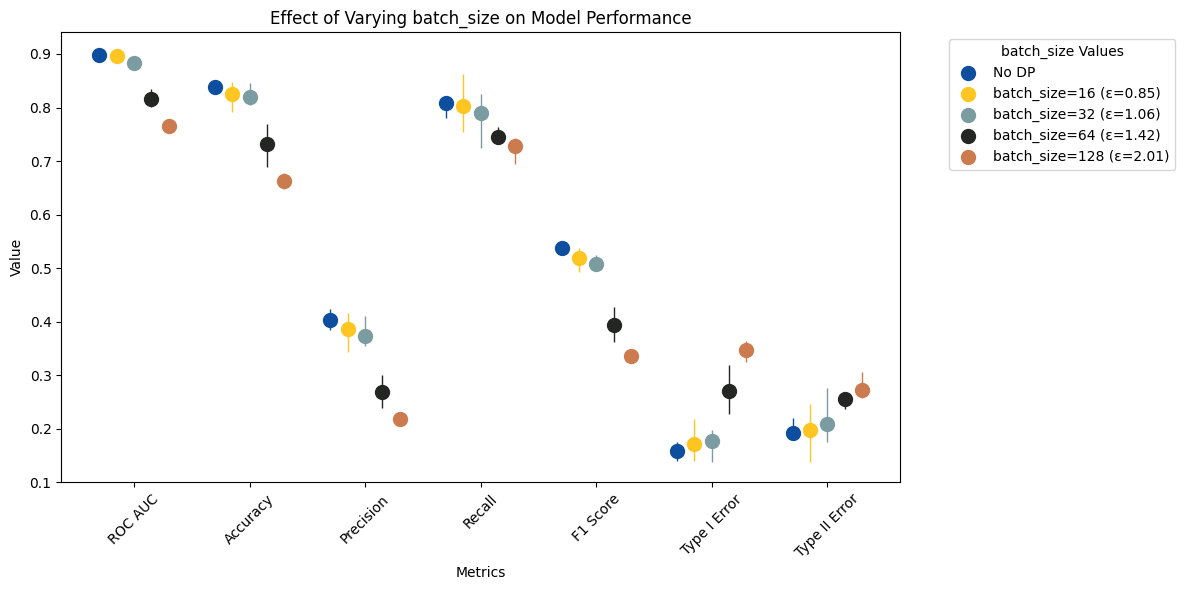

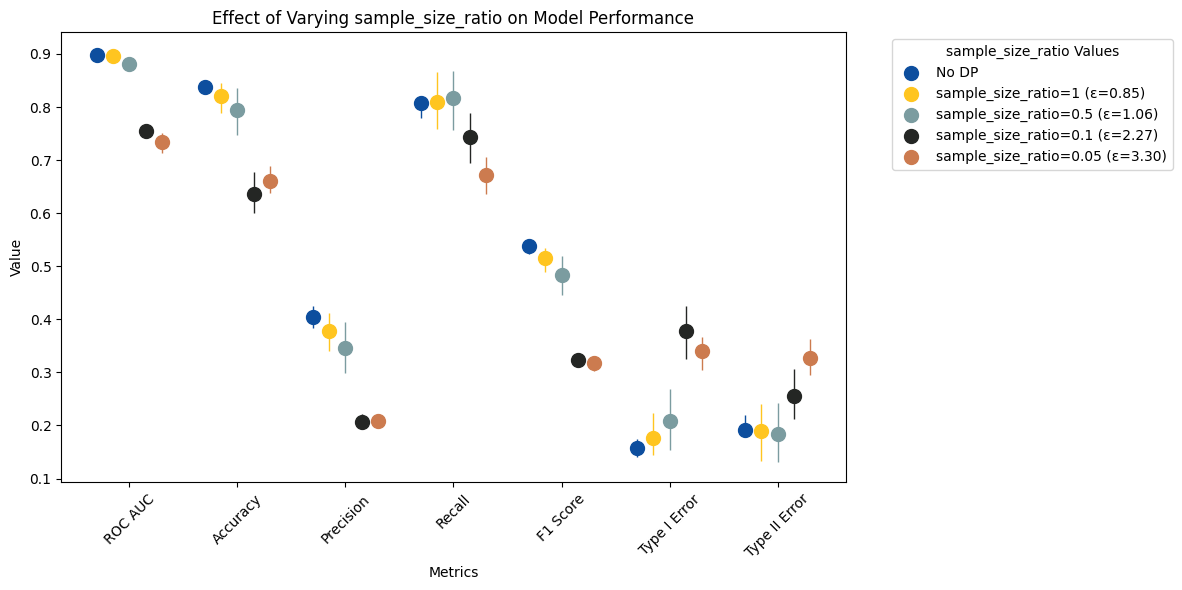

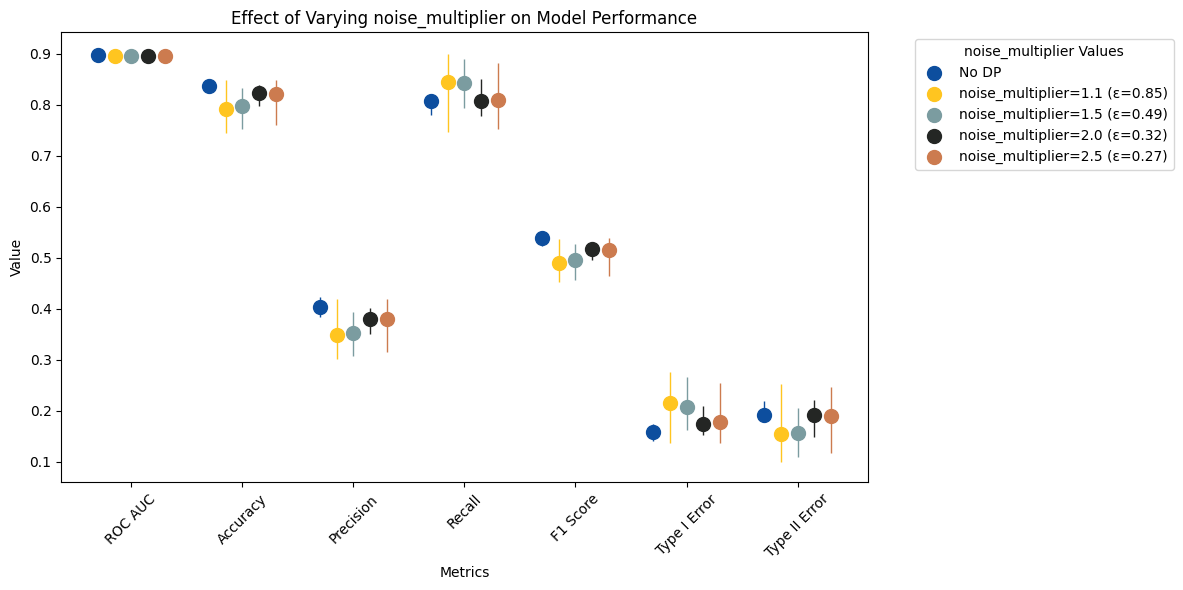

In [29]:

# Define colors
colors = ['#0d4e9e', '#ffc520', '#7b9ca0', '#242624', '#cc7b4f']

# Plot results
plot_parameter_results(results_batch_size, eps_batch_size, 'batch_size', colors, results_no_dp_stats)
plot_parameter_results(results_sample_size, eps_sample_size, 'sample_size_ratio', colors, results_no_dp_stats)
plot_parameter_results(results_noise_multiplier, eps_noise_multiplier, 'noise_multiplier', colors, results_no_dp_stats)